### Imports

In [12]:
from agents.orchestrator import orchestrate
from analytics.themes import detect_theme
import pandas as pd

import sys
import os
import time
import matplotlib.pyplot as plt

In [13]:
PROJECT_ROOT = os.path.abspath("..")
if PROJECT_ROOT not in sys.path:
    sys.path.insert(0, PROJECT_ROOT)

### Create a test dataset

In [14]:
test_queries = [
    {
        "question": "Quelles sont les majeures proposées par l’ESILV ?",
        "expected_theme": "Formations",
        "expected_keywords": ["ingénieur", "l'ESILV", "informatique"]
    },
    {
        "question": "Quels sont les débouchés en data science ?",
        "expected_theme": "Other",
        "expected_keywords": ["data", "emploi", "débouchés", "science", "big"]
    },
    {
        "question": "Quelles destinations internationales l'école propose-t-elle?",
        "expected_theme": "International",
        "expected_keywords": ["mobilité", "Erasmus+", "l'ESILV", "partenaires"]
    },
    {
        "question": "Peux-tu m'en dire plus sur sur les modalités d'inscription à l'ESILV (documents à fournir, dates clés, etc.)?",
        "expected_theme": "Admissions",
        "expected_keywords": ["Parcoursup", "calendrier", "voeux", "dossier", "admission"]
    }
]

### Run queries + measure latency

In [15]:
results = []

for q in test_queries:
    start = time.time()

    decision = orchestrate(
        q["question"], {}  # fake session for evaluation
    )

    latency = time.time() - start

    results.append({
        "question": q["question"],
        "answer": decision["answer"],
        "intent": decision["intent"],
        "latency": latency,
        "n_chunks" : len(decision.get("rag_results", {}).get("sources", [])),
        "rag_sources": decision.get("rag_results", {}).get("sources", [])
    })

### Accuracy metrics

Metric 1 — Keyword overlap

In [16]:
def keyword_accuracy(answer, expected_keywords):
    answer_lower = answer.lower()
    hits = sum(1 for k in expected_keywords if k in answer_lower)
    return hits / len(expected_keywords)

In [17]:
for i, r in enumerate(results):
    r["keyword_accuracy"] = keyword_accuracy(
        r["answer"],
        test_queries[i]["expected_keywords"]
    )

Metric 2 — Theme accuracy

In [18]:
theme_correct = []

for i, r in enumerate(results):
    predicted = detect_theme(r["question"])
    expected = test_queries[i]["expected_theme"]
    theme_correct.append(predicted == expected)
    print("Predicted theme : " + predicted)
    print("Expected theme : " + expected)

theme_accuracy = sum(theme_correct) / len(theme_correct)
print(theme_accuracy)


Predicted theme : Formations
Expected theme : Formations
Predicted theme : Other
Expected theme : Other
Predicted theme : International
Expected theme : International
Predicted theme : Admissions
Expected theme : Admissions
1.0


### Latency plots

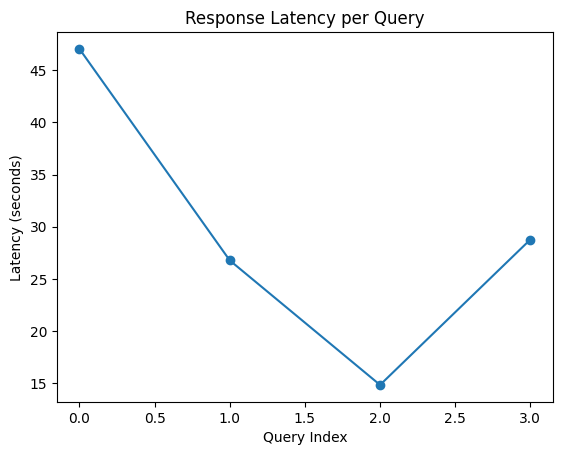

In [19]:
latencies = [r["latency"] for r in results]

plt.figure()
plt.plot(latencies, marker="o")
plt.title("Response Latency per Query")
plt.xlabel("Query Index")
plt.ylabel("Latency (seconds)")
plt.show()

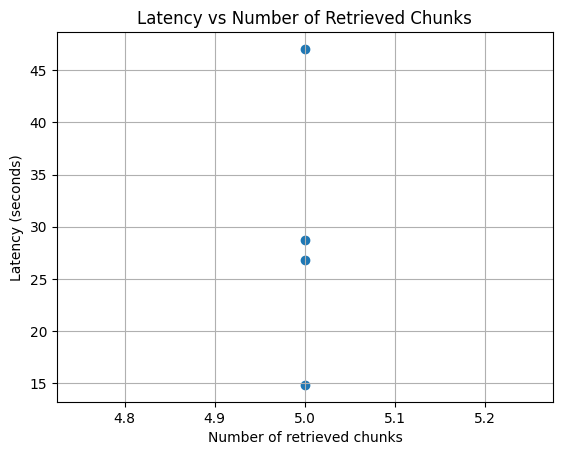

In [20]:
x = [r["n_chunks"] for r in results]
y = [r["latency"] for r in results]

plt.figure()
plt.scatter(x, y)
plt.xlabel("Number of retrieved chunks")
plt.ylabel("Latency (seconds)")
plt.title("Latency vs Number of Retrieved Chunks")
plt.grid(True)
plt.show()

### Tabular results

In [21]:
df = pd.DataFrame(results)
df

,question,answer,intent,latency,n_chunks,rag_sources,keyword_accuracy
0,Quelles sont les majeures proposées par l’ESILV ?,Les neuf majeures proposées à l'ESILV sont :\n...,rag,47.038799,5,[linvisibilite-des-femmes-dans-le-secteur-du-n...,0.666667
1,Quels sont les débouchés en data science ?,Voici les différentes réponses qui apparaissen...,rag,26.770106,5,[quels-sont-les-debouches-en-data-science-pour...,0.400000
2,Quelles destinations internationales l'école p...,Je n'ai pas trouvé d'information spécifique su...,rag,14.834016,5,[loic-promo-2027-une-immersion-academique-et-c...,0.250000
3,Peux-tu m'en dire plus sur sur les modalités d...,D’après le document [Source: admissions_rencon...,rag,28.770458,5,"[dates-de-rentree-2016-207.txt, admissions_ren...",0.200000


In [22]:
for i in range(len(df)):
    print(f"Answer: {df.iloc[i]['answer']}")
    print(f"Keyword Accuracy: {df.iloc[i]['keyword_accuracy']:.2f}")
    print("-" * 40) 

Answer: Les neuf majeures proposées à l'ESILV sont :

1. Informatique, objets connectés et sécurité
2. Ingénierie financière
3. Ingénierie de projets numériques

Et aussi les informations selon les sources fournie indiquent qu'il y a 11 majeures proposées à l'ESILV en première année de cycle ingénieur mais elles ne sont pas toutes mentionnées dans le texte fourni.

Cependant, une autre source indique que certaines majeures sont :
- Informatique, objets connectés et sécurité
- Ingénierie financière 
- etc.
Keyword Accuracy: 0.67
----------------------------------------
Answer: Voici les différentes réponses qui apparaissent dans le texte :

- Data Architecte
- Data Analyst
- Data Scientist
- Ingénieur Big Data
- Chief Data Officer

Ces métiers ont été créés suite à l'essor du big data, et sont souvent nécessaires aux grandes entreprises.
Keyword Accuracy: 0.40
----------------------------------------
Answer: Je n'ai pas trouvé d'information spécifique sur les destinations internationale